In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
from pathlib import Path
from tqdm.notebook import tqdm
import os

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Q1.1: Data Transformation

In [26]:
def round_time(time: str) -> str:
    """
    Round the time to the next hour.
    This function takes a time string in the format "HH:MM" and rounds it to the next hour.
    For example, "12:15" will be rounded to "13:00", and "12:00" will remain "12:00".
    Args:
        time (str): _description_

    Returns:
        str: _description_
    """
    data = time.split(":")
    hour = int(data[0])
    minute = int(data[1])
    hour = hour + 1 if minute > 0 else hour
    return f"{hour:02d}:00"

In [34]:
def add_missing_times(df):
    full_range = [f"{i:02d}:00" for i in range(49)] 
    
    # Create empty DataFrame with complete timeline
    full_df = pd.DataFrame({'Time': full_range})
    
    # Merge with original data
    merged = pd.merge(full_df, df, on='Time', how='left')
    
    return merged

In [ ]:
# Create a dictionary to map the columns to their respective aggregation functions

d = {
    'Age': "last",
    'BUN': "max", 
    'Creatinine': "max", 
    'GCS': "min",
    'Gender': "last", 
    'Glucose': "max",  
    'HCO3': "min",
    'HCT': "min", 
    'HR': "max", 
    'Height': "last", 
    'ICUType': "last", 
    'K': "last", 
    'Mg': "last", 
    'NIDiasABP': "mean", 
    'NIMAP': "mean",
    'NISysABP': "mean", 
    'Na': "min", 
    'Platelets': "min", 
    'RecordID': "last", 
    'RespRate': "max", 
    'Temp': "max",
    'TroponinT': "max", 
    'Urine': "sum", 
    'WBC': "max", 
    'Weight': "last", 
    'ALP': "max", 
    'ALT': "max", 
    'AST': "max", 
    'Albumin': "min",
    'Bilirubin': "max", 
    'FiO2': "last", 
    'MechVent': "last", 
    'PaCO2': "max", 
    'PaO2': "max", 
    'pH': "min", 
    'DiasABP': "mean",
    'MAP': "mean", 
    'SaO2': "min", 
    'SysABP': "mean", 
    'Lactate': "max", 
    'Cholesterol': "last", 
    'TroponinI': "max"
}

# Create a new list of columns in the desired order, i.e., first the static variables followed by the dynamic variables
static_variables = ["Time", "RecordID", "Age", "Gender", "Height", "Weight", "ICUType"]
new_order = static_variables + list(set(d.keys()).difference(set(static_variables)))

In [41]:
# For the three provided datasets we perfrorm the following steps: 
for _set in ["a", "b", "c"]:
    
    # hold the new dataframes in a list
    pivoted_list = []
    for file in Path(f'../data/set-{_set}').glob('*.txt'):
        
        #read each file into a dataframe
        df = pd.read_csv(file)
        
        # apply the rounding function to the Time column
        df["Time"] = df.Time.apply(round_time)
        
        # pivot the dataframe so that all variables are in columns and apply the aggregation functions
        pivoted = df.pivot_table(index='Time', columns='Parameter', values='Value', aggfunc=["sum", "mean", "last", "min", "max"]).reset_index()
        
        # rename the columns base on the aggregation functions
        pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
        pivoted = pivoted[["Time_"] + [f"{v}_{k}" for k, v in d.items() if f"{v}_{k}" in pivoted.columns]]
        
        # remove the prefixes from the columns
        pivoted.columns = [col.split("_")[1] if col != "Time_" else col[:-1] for col in pivoted.columns]
        
        # add missing time rows
        pivoted = add_missing_times(pivoted)
        
        # add the RecordID
        pivoted['RecordID'] = pivoted['RecordID'].iloc[0]
        
        # save the pivoted dataframe into a list
        pivoted_list.append(pivoted)
        
    # concatenating all the pivoted dataframes into one
    dataset = pd.concat(pivoted_list).reset_index(drop=True)
    
    # simplify the RECORD ID values
    dataset["RecordID"] = dataset["RecordID"].astype(int)
    
    # apply the new order to the columns
    dataset = dataset[new_order]
    
    # add the outcome column
    outcomes = pd.read_csv(f"../data/Outcomes-{_set}.txt")
    outcomes = outcomes[["RecordID", "In-hospital_death"]]
    dataset = dataset.set_index("RecordID").join(outcomes.set_index("RecordID")).reset_index()
    
    # write the new dataset to a parquet file
    dataset.to_parquet(f"../data/set-{_set}.parquet", index=False)

# Q1.2 Exploratory Data Analysis

In [ ]:
dataset_a = pd.read_parquet("../data/set-a.parquet")

<Axes: xlabel='In-hospital_death', ylabel='count'>

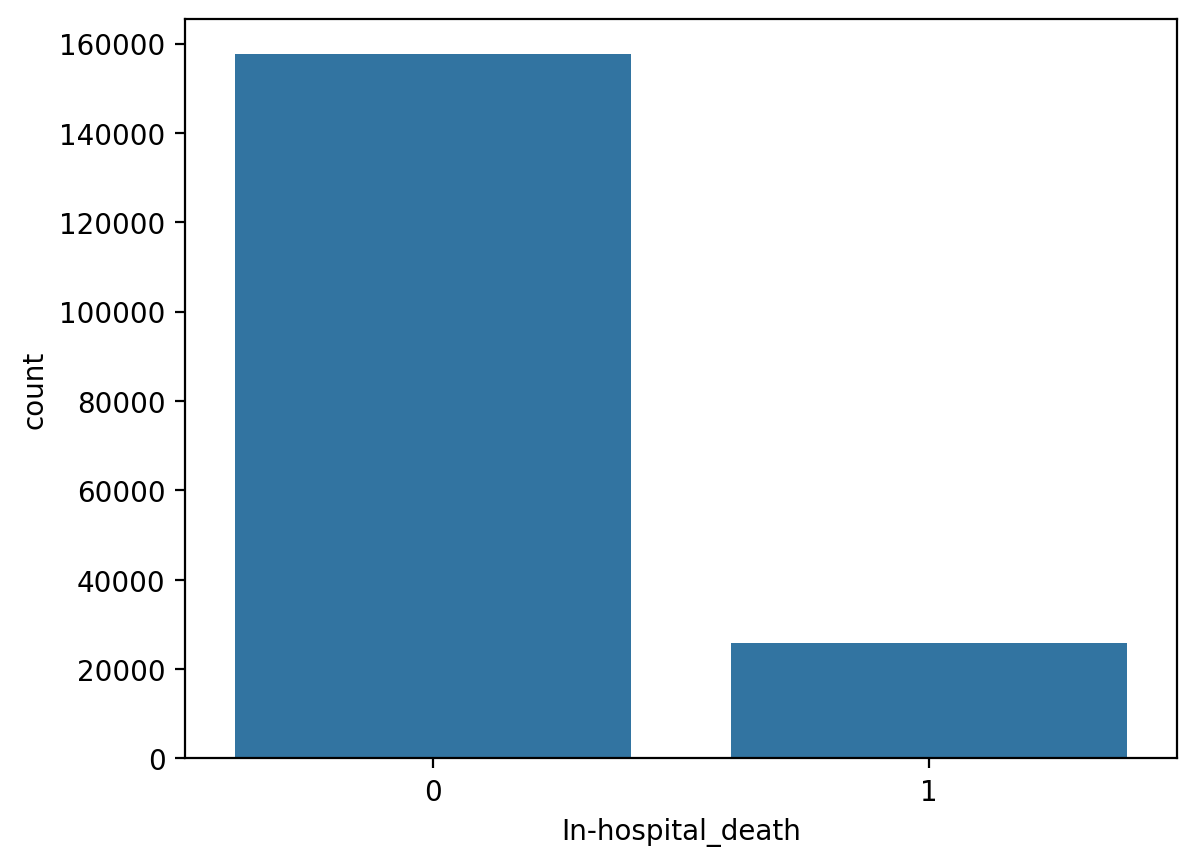

In [7]:
sns.countplot(x="In-hospital_death", data=dataset_a)

# Q1.3 Preprocess data for Machine Learning

## Simple forward fill for the missing values

In [42]:
train = pd.read_parquet("../data/set-a.parquet")
validation = pd.read_parquet("../data/set-b.parquet")
test = pd.read_parquet("../data/set-c.parquet")

- add the missing row when necassary so that every patient has the same number of rows
- perform the feedforward imputation 
- for the remaining values impute using the mean of the colmn

In [72]:
filled_train = train.groupby('RecordID').ffill()
filled_train["RecordID"] = train.RecordID
filled_train

,Time,Age,Gender,Height,Weight,ICUType,TroponinI,HCT,Platelets,Mg,...,Creatinine,Urine,FiO2,HCO3,K,RespRate,ALP,NIMAP,In-hospital_death,RecordID
0,00:00,35.0,0.0,-1.0,71.8,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,132592
1,01:00,35.0,0.0,-1.0,71.8,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,132592
2,02:00,35.0,0.0,-1.0,71.8,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22.0,NaN,68.67,0,132592
3,03:00,35.0,0.0,-1.0,71.8,3.0,NaN,25.5,287.0,2.8,...,2.3,120.0,NaN,11.0,5.3,21.0,NaN,76.67,0,132592
4,04:00,35.0,0.0,-1.0,71.8,3.0,NaN,25.5,287.0,2.8,...,2.3,60.0,NaN,11.0,5.3,24.0,NaN,71.33,0,132592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,56.0,1.0,182.9,100.0,1.0,NaN,34.4,381.0,1.8,...,0.4,50.0,0.4,29.0,4.0,NaN,NaN,NaN,0,141565
195996,45:00,56.0,1.0,182.9,100.0,1.0,NaN,34.4,381.0,1.8,...,0.4,140.0,0.4,29.0,4.0,NaN,NaN,NaN,0,141565
195997,46:00,56.0,1.0,182.9,100.0,1.0,NaN,34.4,381.0,1.8,...,0.4,140.0,0.4,29.0,4.0,NaN,NaN,NaN,0,141565
195998,47:00,56.0,1.0,182.9,100.0,1.0,NaN,34.4,381.0,1.8,...,0.4,80.0,0.4,29.0,4.0,NaN,NaN,NaN,0,141565


In [73]:
numerical_features = filled_train.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])
numerical_features_mean = numerical_features.mean()

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_train[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_train = numerical_features.fillna(-1)
filled_train = filled_train[new_order +  ["In-hospital_death"]]
filled_train

,Time,RecordID,Age,Gender,Height,Weight,ICUType,TroponinI,HCT,Platelets,...,TroponinT,Creatinine,Urine,FiO2,HCO3,K,RespRate,ALP,NIMAP,In-hospital_death
0,00:00,132592,35.0,0.0,-1.0,71.8,3.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,139.302532,0.51966,23.574313,4.11858,19.877148,107.206897,76.411843,0
1,01:00,132592,35.0,0.0,-1.0,71.8,3.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,139.302532,0.51966,23.574313,4.11858,19.877148,107.206897,76.411843,0
2,02:00,132592,35.0,0.0,-1.0,71.8,3.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,139.302532,0.51966,23.574313,4.11858,22.000000,107.206897,68.670000,0
3,03:00,132592,35.0,0.0,-1.0,71.8,3.0,6.747065,25.500000,287.000000,...,0.150000,2.300000,120.000000,0.51966,11.000000,5.30000,21.000000,107.206897,76.670000,0
4,04:00,132592,35.0,0.0,-1.0,71.8,3.0,6.747065,25.500000,287.000000,...,0.150000,2.300000,60.000000,0.51966,11.000000,5.30000,24.000000,107.206897,71.330000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,141565,56.0,1.0,182.9,100.0,1.0,6.747065,34.400000,381.000000,...,0.030000,0.400000,50.000000,0.40000,29.000000,4.00000,19.877148,107.206897,76.411843,0
195996,45:00,141565,56.0,1.0,182.9,100.0,1.0,6.747065,34.400000,381.000000,...,0.030000,0.400000,140.000000,0.40000,29.000000,4.00000,19.877148,107.206897,76.411843,0
195997,46:00,141565,56.0,1.0,182.9,100.0,1.0,6.747065,34.400000,381.000000,...,0.030000,0.400000,140.000000,0.40000,29.000000,4.00000,19.877148,107.206897,76.411843,0
195998,47:00,141565,56.0,1.0,182.9,100.0,1.0,6.747065,34.400000,381.000000,...,0.030000,0.400000,80.000000,0.40000,29.000000,4.00000,19.877148,107.206897,76.411843,0


In [80]:
filled_train.to_parquet("../data/set-a-filled.parquet", index=False)

In [74]:
filled_val = validation.groupby('RecordID').ffill()
filled_val["RecordID"] = validation.RecordID
filled_val

,Time,Age,Gender,Height,Weight,ICUType,TroponinI,HCT,Platelets,Mg,...,Creatinine,Urine,FiO2,HCO3,K,RespRate,ALP,NIMAP,In-hospital_death,RecordID
0,00:00,71.0,1.0,172.7,74.2,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,144404
1,01:00,71.0,1.0,172.7,74.2,4.0,NaN,NaN,NaN,NaN,...,NaN,140.0,0.4,NaN,NaN,NaN,NaN,85.00,0,144404
2,02:00,71.0,1.0,172.7,74.2,4.0,NaN,NaN,NaN,NaN,...,NaN,80.0,0.4,NaN,NaN,NaN,NaN,85.00,0,144404
3,03:00,71.0,1.0,172.7,74.2,4.0,NaN,NaN,NaN,NaN,...,NaN,85.0,0.4,NaN,NaN,NaN,NaN,85.00,0,144404
4,04:00,71.0,1.0,172.7,74.2,4.0,NaN,31.5,510.0,2.2,...,0.6,60.0,0.4,24.0,4.7,NaN,177.0,85.00,0,144404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,85.0,0.0,-1.0,49.3,3.0,NaN,35.0,339.0,2.2,...,2.3,15.0,1.0,16.0,4.9,NaN,NaN,67.67,1,143372
195996,45:00,85.0,0.0,-1.0,49.3,3.0,NaN,35.0,339.0,2.2,...,2.3,15.0,1.0,16.0,4.9,NaN,NaN,67.67,1,143372
195997,46:00,85.0,0.0,-1.0,49.3,3.0,NaN,35.0,339.0,2.2,...,2.3,15.0,1.0,16.0,4.9,NaN,NaN,67.67,1,143372
195998,47:00,85.0,0.0,-1.0,49.3,3.0,NaN,35.0,339.0,2.2,...,2.3,14.0,1.0,16.0,4.9,NaN,NaN,67.67,1,143372


In [ ]:
numerical_features = filled_val.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_val[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_val = numerical_features.fillna(-1)
filled_val = filled_val[new_order +  ["In-hospital_death"]]
filled_val

,Time,RecordID,Age,Gender,Height,Weight,ICUType,TroponinI,HCT,Platelets,...,TroponinT,Creatinine,Urine,FiO2,HCO3,K,RespRate,ALP,NIMAP,In-hospital_death
0,00:00,144404,71.0,1.0,172.7,74.2,4.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,139.302532,0.51966,23.574313,4.11858,19.877148,107.206897,76.411843,0
1,01:00,144404,71.0,1.0,172.7,74.2,4.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,140.000000,0.40000,23.574313,4.11858,19.877148,107.206897,85.000000,0
2,02:00,144404,71.0,1.0,172.7,74.2,4.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,80.000000,0.40000,23.574313,4.11858,19.877148,107.206897,85.000000,0
3,03:00,144404,71.0,1.0,172.7,74.2,4.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,85.000000,0.40000,23.574313,4.11858,19.877148,107.206897,85.000000,0
4,04:00,144404,71.0,1.0,172.7,74.2,4.0,6.747065,31.500000,510.000000,...,1.056302,0.600000,60.000000,0.40000,24.000000,4.70000,19.877148,177.000000,85.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,143372,85.0,0.0,-1.0,49.3,3.0,6.747065,35.000000,339.000000,...,0.010000,2.300000,15.000000,1.00000,16.000000,4.90000,19.877148,107.206897,67.670000,1
195996,45:00,143372,85.0,0.0,-1.0,49.3,3.0,6.747065,35.000000,339.000000,...,0.010000,2.300000,15.000000,1.00000,16.000000,4.90000,19.877148,107.206897,67.670000,1
195997,46:00,143372,85.0,0.0,-1.0,49.3,3.0,6.747065,35.000000,339.000000,...,0.010000,2.300000,15.000000,1.00000,16.000000,4.90000,19.877148,107.206897,67.670000,1
195998,47:00,143372,85.0,0.0,-1.0,49.3,3.0,6.747065,35.000000,339.000000,...,0.010000,2.300000,14.000000,1.00000,16.000000,4.90000,19.877148,107.206897,67.670000,1


In [79]:
filled_val.to_parquet("../data/set-b-filled.parquet", index=False)

In [76]:
filled_test = test.groupby('RecordID').ffill()
filled_test["RecordID"] = test.RecordID
filled_test

,Time,Age,Gender,Height,Weight,ICUType,TroponinI,HCT,Platelets,Mg,...,Creatinine,Urine,FiO2,HCO3,K,RespRate,ALP,NIMAP,In-hospital_death,RecordID
0,00:00,58.0,1.0,-1.0,-1.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,154617
1,01:00,58.0,1.0,-1.0,-1.0,4.0,NaN,NaN,NaN,NaN,...,NaN,300.0,NaN,NaN,NaN,19.0,NaN,73.3325,0,154617
2,02:00,58.0,1.0,-1.0,-1.0,4.0,NaN,26.2,313.0,1.4,...,0.5,100.0,NaN,21.0,4.2,21.0,NaN,73.3325,0,154617
3,03:00,58.0,1.0,-1.0,-1.0,4.0,NaN,23.2,357.0,1.4,...,0.5,60.0,NaN,22.0,4.0,19.0,NaN,73.3325,0,154617
4,04:00,58.0,1.0,-1.0,-1.0,4.0,NaN,23.2,357.0,1.4,...,0.5,50.0,NaN,22.0,4.0,19.0,NaN,73.3325,0,154617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,50.0,1.0,-1.0,45.5,1.0,NaN,35.0,115.0,2.8,...,5.4,NaN,NaN,27.0,3.8,12.0,NaN,80.0000,0,153161
195996,45:00,50.0,1.0,-1.0,45.5,1.0,NaN,33.6,112.0,2.1,...,6.8,NaN,NaN,26.0,4.3,12.0,NaN,80.0000,0,153161
195997,46:00,50.0,1.0,-1.0,45.5,1.0,NaN,33.6,112.0,2.1,...,6.8,NaN,NaN,26.0,4.3,12.0,NaN,94.0000,0,153161
195998,47:00,50.0,1.0,-1.0,45.5,1.0,NaN,33.6,112.0,2.1,...,6.8,NaN,NaN,26.0,4.3,9.0,NaN,90.6700,0,153161


In [77]:
numerical_features = filled_test.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_test[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_test = numerical_features.fillna(-1)
filled_test = filled_test[new_order +  ["In-hospital_death"]]
filled_test

,Time,RecordID,Age,Gender,Height,Weight,ICUType,TroponinI,HCT,Platelets,...,TroponinT,Creatinine,Urine,FiO2,HCO3,K,RespRate,ALP,NIMAP,In-hospital_death
0,00:00,154617,58.0,1.0,-1.0,-1.0,4.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,139.302532,0.51966,23.574313,4.11858,19.877148,107.206897,76.411843,0
1,01:00,154617,58.0,1.0,-1.0,-1.0,4.0,6.747065,31.583625,205.438863,...,1.056302,1.378062,300.000000,0.51966,23.574313,4.11858,19.000000,107.206897,73.332500,0
2,02:00,154617,58.0,1.0,-1.0,-1.0,4.0,6.747065,26.200000,313.000000,...,1.056302,0.500000,100.000000,0.51966,21.000000,4.20000,21.000000,107.206897,73.332500,0
3,03:00,154617,58.0,1.0,-1.0,-1.0,4.0,6.747065,23.200000,357.000000,...,1.056302,0.500000,60.000000,0.51966,22.000000,4.00000,19.000000,107.206897,73.332500,0
4,04:00,154617,58.0,1.0,-1.0,-1.0,4.0,6.747065,23.200000,357.000000,...,1.056302,0.500000,50.000000,0.51966,22.000000,4.00000,19.000000,107.206897,73.332500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,153161,50.0,1.0,-1.0,45.5,1.0,6.747065,35.000000,115.000000,...,4.880000,5.400000,139.302532,0.51966,27.000000,3.80000,12.000000,107.206897,80.000000,0
195996,45:00,153161,50.0,1.0,-1.0,45.5,1.0,6.747065,33.600000,112.000000,...,4.880000,6.800000,139.302532,0.51966,26.000000,4.30000,12.000000,107.206897,80.000000,0
195997,46:00,153161,50.0,1.0,-1.0,45.5,1.0,6.747065,33.600000,112.000000,...,4.880000,6.800000,139.302532,0.51966,26.000000,4.30000,12.000000,107.206897,94.000000,0
195998,47:00,153161,50.0,1.0,-1.0,45.5,1.0,6.747065,33.600000,112.000000,...,4.880000,6.800000,139.302532,0.51966,26.000000,4.30000,9.000000,107.206897,90.670000,0


In [78]:
filled_test.to_parquet("../data/set-c-filled.parquet", index=False)

In [81]:
# TODO: Data should be normalized after Q1.2